In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2 as cv

In [2]:
DATA_FOLDER = '/kaggle/input/deep-fake-detection-cropped-dataset'
FAKE_FOLDER = 'DFDC_Dataset/Fake'
REAL_FOLDER = 'DFDC_Dataset/Real'

print(f"Fake samples: {len(os.listdir(os.path.join(DATA_FOLDER, FAKE_FOLDER)))}")
print(f"Real samples: {len(os.listdir(os.path.join(DATA_FOLDER, REAL_FOLDER)))}")

Fake samples: 1566
Real samples: 1727


In [3]:
fake_list = list(os.listdir(os.path.join(DATA_FOLDER, FAKE_FOLDER)))
ext_dict = []
for file in fake_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")      

Extensions: ['mp4']


In [4]:
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in fake_list if  file.endswith(file_ext)])}")

Files with extension `mp4`: 1566


In [7]:
real_list = list(os.listdir(os.path.join(DATA_FOLDER, REAL_FOLDER)))
ext_dict = []
for file in real_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")      

Extensions: ['mp4']


In [8]:
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in real_list if  file.endswith(file_ext)])}")

Files with extension `mp4`: 1727


In [9]:
import shutil
from sklearn.model_selection import train_test_split

In [10]:
real_path = '/kaggle/working/real'
fake_path = '/kaggle/working/fake'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

os.makedirs(f"{train_dir}/real", exist_ok=True)
os.makedirs(f"{train_dir}/fake", exist_ok=True)
os.makedirs(f"{test_dir}/real", exist_ok=True)
os.makedirs(f"{test_dir}/fake", exist_ok=True)

In [11]:
fake_videos = os.listdir(os.path.join(DATA_FOLDER, FAKE_FOLDER))
real_videos = os.listdir(os.path.join(DATA_FOLDER, REAL_FOLDER))

In [12]:
real_train, real_test = train_test_split(real_videos, test_size=0.2, random_state=42)
fake_train, fake_test = train_test_split(fake_videos, test_size=0.2, random_state=42)

In [13]:
def copy_files(file_list, source_dir, dest_dir):
    for file in file_list:
        shutil.copy(os.path.join(source_dir, file), os.path.join(dest_dir, file))

In [14]:
copy_files(real_train, os.path.join(DATA_FOLDER, REAL_FOLDER), f"{train_dir}/real")
copy_files(real_test, os.path.join(DATA_FOLDER, REAL_FOLDER), f"{test_dir}/real")

copy_files(fake_train, os.path.join(DATA_FOLDER, FAKE_FOLDER), f"{train_dir}/fake")
copy_files(fake_test, os.path.join(DATA_FOLDER, FAKE_FOLDER), f"{test_dir}/fake")

print("Train-test split completed.")

Train-test split completed.


In [15]:
TRAIN_FAKE_FOLDER = '/kaggle/working/train/fake'
TRAIN_REAL_FOLDER = '/kaggle/working/train/real'
TEST_FAKE_FOLDER = '/kaggle/working/test/fake'
TEST_REAL_FOLDER = '/kaggle/working/test/real'

print(f"Training Fake samples: {len(os.listdir(TRAIN_FAKE_FOLDER))}")
print(f"Training Real samples: {len(os.listdir(TRAIN_REAL_FOLDER))}")
print(f"Testing Fake samples: {len(os.listdir(TEST_FAKE_FOLDER))}")
print(f"Testing Real samples: {len(os.listdir(TEST_REAL_FOLDER))}")

Training Fake samples: 1252
Training Real samples: 1381
Testing Fake samples: 314
Testing Real samples: 346


In [16]:
import math
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Dense, Dropout, LSTM, BatchNormalization, GRU
from keras.layers import ConvLSTM2D
from tensorflow.keras.applications import EfficientNetB0
from keras.regularizers import l2

In [18]:
import math
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

In [19]:
def extract_frames(video_path, output_folder, num_frames=8):
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, max(total_frames - 1, 0), num_frames, dtype=int)
    
    os.makedirs(output_folder, exist_ok=True)
    current_frame = 0
    saved_frame = 0
    ret = True
    frames_dict = {}  
    while ret and saved_frame < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if current_frame in indices:
            frame_path = os.path.join(output_folder, f"frame_{saved_frame}.jpg")
            cv.imwrite(frame_path, frame)
            saved_frame += 1
        current_frame += 1
    cap.release()

In [20]:
BASE_DATA_DIR = '/kaggle/working'
VIDEO_ROOT = BASE_DATA_DIR  
VIDEO_DIRS = {
    'train/real': os.path.join(VIDEO_ROOT, 'train/real'),
    'train/fake': os.path.join(VIDEO_ROOT, 'train/fake'),
    'test/real': os.path.join(VIDEO_ROOT, 'test/real'),
    'test/fake': os.path.join(VIDEO_ROOT, 'test/fake')
}

In [21]:
VIDEO_DIRS

{'train/real': '/kaggle/working/train/real',
 'train/fake': '/kaggle/working/train/fake',
 'test/real': '/kaggle/working/test/real',
 'test/fake': '/kaggle/working/test/fake'}

In [22]:
EXTRACTED_ROOT = os.path.join(BASE_DATA_DIR, 'extracted_seq')
for subset in ['train', 'test']:
    for label in ['real', 'fake']:
        os.makedirs(os.path.join(EXTRACTED_ROOT, subset, label), exist_ok=True)

In [23]:
for key, folder in VIDEO_DIRS.items():
    subset, label = key.split('/')
    video_files = os.listdir(folder)
    print(f"Extracting frames for {subset}/{label} ...")
    for video_file in video_files:
        video_path = os.path.join(folder, video_file)
        video_name = os.path.splitext(video_file)[0]
        output_folder = os.path.join(EXTRACTED_ROOT, subset, label, video_name)
        extract_frames(video_path, output_folder, num_frames=16)
print("Frame extraction completed.")

Extracting frames for train/real ...
Extracting frames for train/fake ...
Extracting frames for test/real ...
Extracting frames for test/fake ...
Frame extraction completed.


In [24]:
print(f"Extracted Sequence Train Real Size: {len(os.listdir('/kaggle/working/extracted_seq/train/real'))}")
print(f"Extracted Sequence Train Fake Size: {len(os.listdir('/kaggle/working/extracted_seq/train/fake'))}")
print(f"Extracted Sequence Test Rea; Size: {len(os.listdir('/kaggle/working/extracted_seq/test/real'))}")
print(f"Extracted Sequence Test Fake Size: {len(os.listdir('/kaggle/working/extracted_seq/test/fake'))}")

Extracted Sequence Train Real Size: 1381
Extracted Sequence Train Fake Size: 1252
Extracted Sequence Test Rea; Size: 346
Extracted Sequence Test Fake Size: 314


In [25]:
class VideoSequenceGenerator(Sequence):
    def __init__(self, root_dir, subset, batch_size=8, num_frames=8, target_size=(224, 224), shuffle=True):
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.target_size = target_size
        self.shuffle = shuffle
        self.samples = []
        
        for label_idx, label in enumerate(['real', 'fake']):
            label_folder = os.path.join(root_dir, subset, label)
            video_names = os.listdir(label_folder)
            for video_name in video_names:
                video_seq_path = os.path.join(label_folder, video_name)
                self.samples.append((video_seq_path, label_idx))
                
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.samples) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.samples)
    
    def __getitem__(self, idx):
        batch_samples = self.samples[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_data = []
        batch_labels = []
        for video_seq_path, label in batch_samples:
            frame_files = sorted([os.path.join(video_seq_path, f) 
                                  for f in os.listdir(video_seq_path) if f.endswith('.jpg')])
            if len(frame_files) < self.num_frames:
                while len(frame_files) < self.num_frames:
                    frame_files.append(frame_files[-1])
            elif len(frame_files) > self.num_frames:
                frame_files = frame_files[:self.num_frames]
            frames = []
            for frame_file in frame_files:
                img = cv.imread(frame_file)
                img = cv.resize(img, self.target_size)
                img = img.astype('float32') / 255.0
                frames.append(img)
            video_array = np.array(frames)
            batch_data.append(video_array)
            batch_labels.append(label)
        return np.array(batch_data), np.array(batch_labels)

In [26]:
BATCH_SIZE = 8
NUM_FRAMES = 8
TARGET_SIZE = (224, 224)

train_gen = VideoSequenceGenerator(EXTRACTED_ROOT, subset='train', batch_size=BATCH_SIZE, 
                                   num_frames=NUM_FRAMES, target_size=TARGET_SIZE, shuffle=True)
test_gen = VideoSequenceGenerator(EXTRACTED_ROOT, subset='test', batch_size=BATCH_SIZE, 
                                  num_frames=NUM_FRAMES, target_size=TARGET_SIZE, shuffle=False)

In [27]:
input_shape = (NUM_FRAMES, TARGET_SIZE[0], TARGET_SIZE[1], 3)
video_input = Input(shape=input_shape)

In [28]:
cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
cnn_base.trainable = False

td_cnn = TimeDistributed(cnn_base)(video_input)
td_pool = TimeDistributed(GlobalAveragePooling2D())(td_cnn)

lstm_out = LSTM(64, return_sequences=False)(td_pool)
dense_out = Dense(64, activation='relu')(lstm_out)
final_out = Dense(1, activation='sigmoid')(dense_out)

model = Model(inputs=video_input, outputs=final_out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8, 224, 224, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 7, 7, 1280)       │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 8, 1280)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         344,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,606,529 (9.94 MB)

 Trainable params: 348,545 (1.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
EPOCHS = 12
history = model.fit(train_gen, epochs=EPOCHS, validation_data=test_gen)

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


330/330 ━━━━━━━━━━━━━━━━━━━━ 89s 177ms/step - accuracy: 0.5931 - loss: 0.6721 - val_accuracy: 0.6909 - val_loss: 0.5843
Epoch 2/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.6581 - loss: 0.6097 - val_accuracy: 0.7076 - val_loss: 0.5674
Epoch 3/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 52s 157ms/step - accuracy: 0.7079 - loss: 0.5643 - val_accuracy: 0.7045 - val_loss: 0.5649
Epoch 4/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.7582 - loss: 0.5095 - val_accuracy: 0.7303 - val_loss: 0.5503
Epoch 5/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.7685 - loss: 0.4820 - val_accuracy: 0.6818 - val_loss: 0.5995
Epoch 6/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.7771 - loss: 0.4557 - val_accuracy: 0.7333 - val_loss: 0.5538
Epoch 7/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.8226 - loss: 0.3947 - val_accuracy: 0.7742 - val_loss: 0.4738
Epoch 8/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.8324 - loss: 0.3904 - val

In [30]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8795 - loss: 0.2790
Test Accuracy: 79.85%


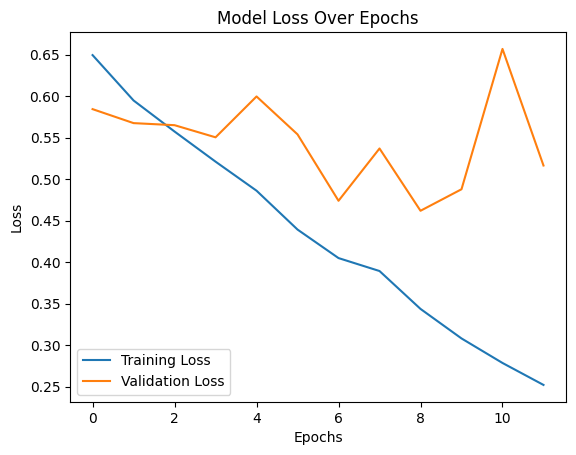

In [31]:
  plt.plot(history.history['loss'], label='Training Loss')
  if 'val_loss' in history.history:
      plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

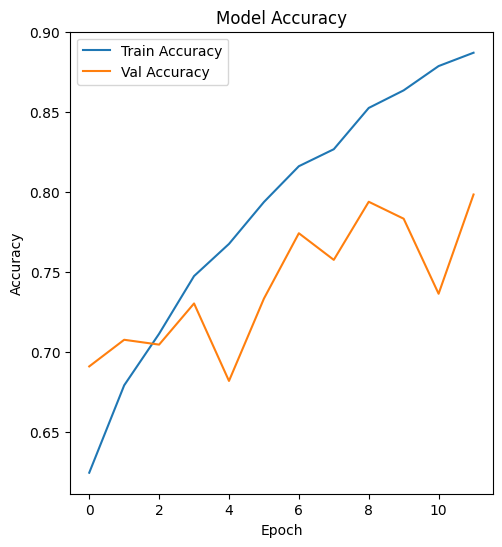

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

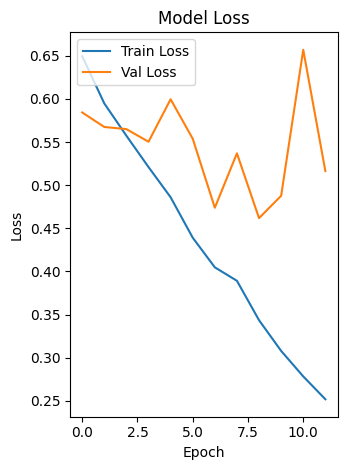

In [33]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
y_true = []
y_pred = []

for batch_data, batch_labels in test_gen:
    preds = model.predict(batch_data)
    y_true.extend(batch_labels)
    y_pred.extend((preds > 0.5).astype(int))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error

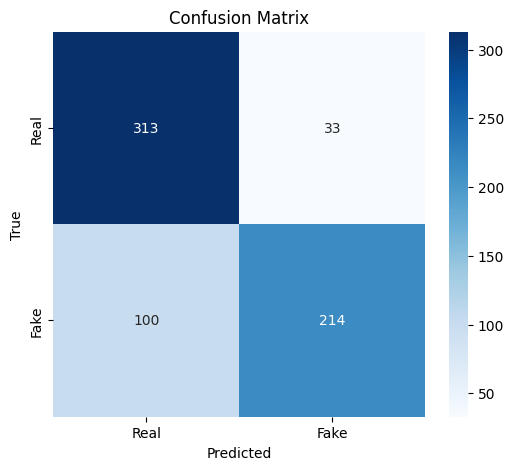

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [39]:
model.save('final_model.h5')